In [1]:
!pip install rank_bm25 rbo sentence-transformers


In [2]:
import json

def parse_our_model_with_queries(path):
    with open(path, "r", encoding="utf-8", errors="replace") as f:
        lines = f.readlines()

    results = []
    i = 0
    n = len(lines)

    while i < n:
        line = lines[i].strip()

        # Ищем строку с запросом
        if line.startswith("Текст:"):
            # 1) Парсим текст запроса
            query = line[len("Текст:"):].strip()

            # 2) Двигаемся дальше до JSON-ответа
            i += 1
            while i < n and not lines[i].lstrip().startswith("{"):
                i += 1

            if i >= n:
                break  # дошли до конца, JSON не нашли

            # 3) Собираем JSON-блок с балансировкой скобок
            json_lines = []
            brace_level = 0
            started = False

            while i < n:
                l = lines[i]
                json_lines.append(l)

                # считаем фигурные скобки
                for ch in l:
                    if ch == '{':
                        brace_level += 1
                        started = True
                    elif ch == '}':
                        brace_level -= 1

                i += 1
                if started and brace_level == 0:
                    break

            json_str = "".join(json_lines).strip()

            # 4) Парсим JSON
            try:
                obj = json.loads(json_str)
                raw_games = obj.get("data", "")
                games = [g.strip() for g in raw_games.split(",") if g.strip()]
                results.append({
                    "query": query,
                    "games": games
                })
            except json.JSONDecodeError as e:
                # если что-то пошло не так — можно залогировать
                print("Ошибка JSON для запроса:", query)
                print("Причина:", e)
                # и просто пропустить этот блок
                continue

        else:
            i += 1

    return results


parsed = parse_our_model_with_queries('/content/data (2).txt')

print("Найдено пар (запрос + ответ):", len(parsed))
print("Пример первой пары:")
parsed[0]


Найдено пар (запрос + ответ): 499
Пример первой пары:


{'query': 'Посоветуй, пожалуйста, хорошую сюжетную игру на 20–30 часов.',
 'games': ['The Witcher 3: Wild Hunt',
  'Red Dead Redemption 2',
  'Mass Effect: Legendary Edition',
  'Persona 5 Royal',
  'Horizon Zero Dawn']}

In [3]:
import json
import pandas as pd

# путь к файлу (в коллабе загрузи через upload)
json_path = "/content/queries_part1_full.json"

# Читаем JSON baseline модели
with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

results = data["results"]

# Преобразуем в список словарей
baseline_rows = []
for i, item in enumerate(results, start=1):
    baseline_rows.append({
        "index": i,
        "query": item["query"],
        "baseline_answer": item["response"],
    })

df_baseline = pd.DataFrame(baseline_rows)

print("Пример данных baseline:")
df_baseline.head()


Пример данных baseline:


,index,query,baseline_answer
0,1,"Посоветуй, пожалуйста, хорошую сюжетную игру н...","Control, A Plague Tale: Innocence, Prey, BioSh..."
1,2,Хочу что-то похожее на Divinity: Original Sin ...,"Shadowrun: Dragonfall, Wasteland 3, South Park..."
2,3,"Посоветуй шутер с тактическими элементами, но ...","Star Wars: Republic Commando, The Division, Sn..."
3,4,"Дай игру в жанре cozy, чтобы расслабиться вече...","A Short Hike, Unpacking, Spiritfarer, Garden P..."
4,5,"Ищу что-то похожее на Hollow Knight, но менее ...","Yoku's Island Express, Ender Lilies: Quietus o..."


In [4]:
baseline_processed = []

for row in df_baseline.to_dict("records"):
    games = [g.strip() for g in row["baseline_answer"].split(",")]
    baseline_processed.append({
        "query": row["query"],
        "baseline_games": games,
        "baseline_str": row["baseline_answer"],
    })

df_baseline_clean = pd.DataFrame(baseline_processed)
df_baseline_clean.head()

,query,baseline_games,baseline_str
0,"Посоветуй, пожалуйста, хорошую сюжетную игру н...","[Control, A Plague Tale: Innocence, Prey, BioS...","Control, A Plague Tale: Innocence, Prey, BioSh..."
1,Хочу что-то похожее на Divinity: Original Sin ...,"[Shadowrun: Dragonfall, Wasteland 3, South Par...","Shadowrun: Dragonfall, Wasteland 3, South Park..."
2,"Посоветуй шутер с тактическими элементами, но ...","[Star Wars: Republic Commando, The Division, S...","Star Wars: Republic Commando, The Division, Sn..."
3,"Дай игру в жанре cozy, чтобы расслабиться вече...","[A Short Hike, Unpacking, Spiritfarer, Garden ...","A Short Hike, Unpacking, Spiritfarer, Garden P..."
4,"Ищу что-то похожее на Hollow Knight, но менее ...","[Yoku's Island Express, Ender Lilies: Quietus ...","Yoku's Island Express, Ender Lilies: Quietus o..."


In [5]:
our_processed = []

for item in parsed:
    our_processed.append({
        "query": item["query"],
        "our_games": item["games"],
        "our_str": ", ".join(item["games"])
    })

df_our_clean = pd.DataFrame(our_processed)
df_our_clean.head()

,query,our_games,our_str
0,"Посоветуй, пожалуйста, хорошую сюжетную игру н...","[The Witcher 3: Wild Hunt, Red Dead Redemption...","The Witcher 3: Wild Hunt, Red Dead Redemption ..."
1,Хочу что-то похожее на Divinity: Original Sin ...,"[Cris Tales, DUNGEON ENCOUNTERS, Sword of Elpi...","Cris Tales, DUNGEON ENCOUNTERS, Sword of Elpis..."
2,"Посоветуй шутер с тактическими элементами, но ...","[TO4: Tactical Operations, Tactical Suppressio...","TO4: Tactical Operations, Tactical Suppression..."
3,"Дай игру в жанре cozy, чтобы расслабиться вече...","[Chill X, Zen Trails, Click and Relax, Home De...","Chill X, Zen Trails, Click and Relax, Home Des..."
4,"Ищу что-то похожее на Hollow Knight, но менее ...","[Dungeon of Zolthan, Cave Story+, Insanely Twi...","Dungeon of Zolthan, Cave Story+, Insanely Twis..."


In [6]:
df_full = df_our_clean.merge(df_baseline_clean, on="query", how="inner")

# Добавим индекс
df_full.insert(0, "index", range(1, len(df_full)+1))

len(df_full)

448

In [8]:
import numpy as np
from sentence_transformers import SentenceTransformer
import rbo

model = SentenceTransformer("all-MiniLM-L6-v2")

def jaccard(a, b):
    set_a, set_b = set(a), set(b)
    return len(set_a & set_b) / len(set_a | set_b) if (set_a | set_b) else 0

def overlap_at_5(a, b):
    return len(set(a) & set(b))

def embedding_similarity(list1, list2):
    if not list1 or not list2:
        return 0

    emb1 = model.encode(list1, normalize_embeddings=True)
    emb2 = model.encode(list2, normalize_embeddings=True)

    mean1 = emb1.mean(axis=0)
    mean2 = emb2.mean(axis=0)

    return float(np.dot(mean1, mean2))


df_full["overlap5"] = df_full.apply(lambda row: overlap_at_5(row["our_games"], row["baseline_games"]), axis=1)
df_full["jaccard"] = df_full.apply(lambda row: jaccard(row["our_games"], row["baseline_games"]), axis=1)
df_full["embed_sim"] = df_full.apply(lambda row: embedding_similarity(row["our_games"], row["baseline_games"]), axis=1)

df_full.head()


,index,query,our_games,our_str,baseline_games,baseline_str,overlap5,jaccard,embed_sim,rbo
0,1,"Посоветуй, пожалуйста, хорошую сюжетную игру н...","[The Witcher 3: Wild Hunt, Red Dead Redemption...","The Witcher 3: Wild Hunt, Red Dead Redemption ...","[Control, A Plague Tale: Innocence, Prey, BioS...","Control, A Plague Tale: Innocence, Prey, BioSh...",0,0.0,0.250718,0
1,2,Хочу что-то похожее на Divinity: Original Sin ...,"[Cris Tales, DUNGEON ENCOUNTERS, Sword of Elpi...","Cris Tales, DUNGEON ENCOUNTERS, Sword of Elpis...","[Shadowrun: Dragonfall, Wasteland 3, South Par...","Shadowrun: Dragonfall, Wasteland 3, South Park...",0,0.0,0.204715,0
2,3,"Посоветуй шутер с тактическими элементами, но ...","[TO4: Tactical Operations, Tactical Suppressio...","TO4: Tactical Operations, Tactical Suppression...","[Star Wars: Republic Commando, The Division, S...","Star Wars: Republic Commando, The Division, Sn...",0,0.0,0.253839,0
3,4,"Дай игру в жанре cozy, чтобы расслабиться вече...","[Chill X, Zen Trails, Click and Relax, Home De...","Chill X, Zen Trails, Click and Relax, Home Des...","[A Short Hike, Unpacking, Spiritfarer, Garden ...","A Short Hike, Unpacking, Spiritfarer, Garden P...",0,0.0,0.147889,0
4,5,"Ищу что-то похожее на Hollow Knight, но менее ...","[Dungeon of Zolthan, Cave Story+, Insanely Twi...","Dungeon of Zolthan, Cave Story+, Insanely Twis...","[Yoku's Island Express, Ender Lilies: Quietus ...","Yoku's Island Express, Ender Lilies: Quietus o...",0,0.0,0.219845,0


In [11]:
import numpy as np
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")

def embed_list(games):
    if not games:
        return np.zeros((1, 384))
    return model.encode(games, normalize_embeddings=True)


In [12]:
def semantic_rbo(listA, listB, p=0.9):
    # эмбеддинги
    A = embed_list(listA)
    B = embed_list(listB)

    # Матрица попарных cosine similarity
    sim_matrix = np.dot(A, B.T)  # shape: len(A) x len(B)

    # Для каждого элемента A → выбираем best match в B
    # Это заменяет прямое совпадение игр
    sim_scores = sim_matrix.max(axis=1)

    # RBO-like aggregation:
    # top-weighted average of similarity scores
    rbo = 0
    weight = 1 - p

    for k in range(1, len(sim_scores) + 1):
        rbo += weight * (p ** (k - 1)) * sim_scores[k - 1]

    return float(rbo)


In [13]:
def semantic_mrr(listA, listB):
    A = embed_list(listA)
    B = embed_list(listB)
    sim_matrix = np.dot(A, B.T)

    mrr_total = 0
    for i in range(len(A)):
        # сортируем по убыванию похожести
        ranks = np.argsort(-sim_matrix[i])
        # всегда 0-й — лучший матч
        mrr_total += 1 / (ranks[0] + 1)

    return mrr_total / len(A)


In [14]:
def ndcg_at_k(rels, k=5):
    rels = np.array(rels[:k])
    dcg = np.sum((2**rels - 1) / np.log2(np.arange(1, len(rels)+1) + 1))
    ideal = np.sort(rels)[::-1]
    idcg = np.sum((2**ideal - 1) / np.log2(np.arange(1, len(ideal)+1) + 1))
    return dcg / idcg if idcg > 0 else 0

def semantic_ndcg(listA, listB):
    A = embed_list(listA)
    B = embed_list(listB)
    sim_matrix = np.dot(A, B.T)

    # максимум схожести для каждого элемента → список релевантностей
    rels = sim_matrix.max(axis=1)
    return ndcg_at_k(rels, k=5)


In [15]:
df_full["semantic_rbo"] = df_full.apply(
    lambda row: semantic_rbo(row["our_games"], row["baseline_games"]),
    axis=1
)

df_full["semantic_mrr"] = df_full.apply(
    lambda row: semantic_mrr(row["our_games"], row["baseline_games"]),
    axis=1
)

df_full["semantic_ndcg"] = df_full.apply(
    lambda row: semantic_ndcg(row["our_games"], row["baseline_games"]),
    axis=1
)


In [21]:
df_full["final_score"] = (
    0.25 * df_full["embed_sim"] +
    0.25 * df_full["semantic_rbo"] +
    0.20 * df_full["semantic_ndcg"] +
    0.20 * df_full["semantic_mrr"] +
    0.10 * df_full["jaccard"]
)

df_full["final_percent"] = df_full["final_score"] * 100




In [22]:
report_stats = df_full[[
    "overlap5", "jaccard", "embed_sim",
    "semantic_rbo", "semantic_mrr", "semantic_ndcg",
    "final_score"
]].mean()

report_stats


,0
overlap5,1.189732
jaccard,0.162584
embed_sim,0.369376
semantic_rbo,0.239713
semantic_mrr,0.672082
semantic_ndcg,0.910774
final_score,0.485102


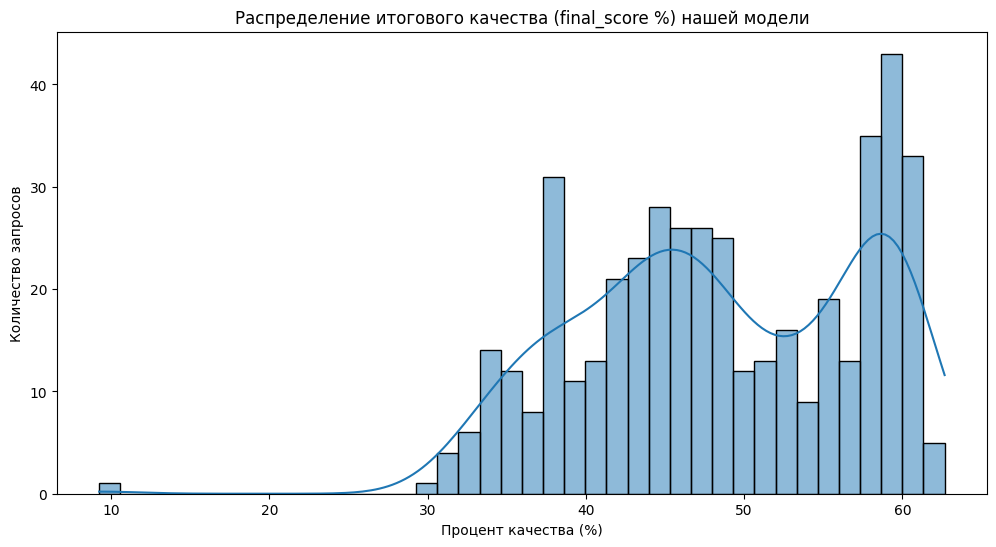

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.histplot(df_full["final_percent"], bins=40, kde=True)
plt.title("Распределение итогового качества (final_score %) нашей модели")
plt.xlabel("Процент качества (%)")
plt.ylabel("Количество запросов")
plt.show()


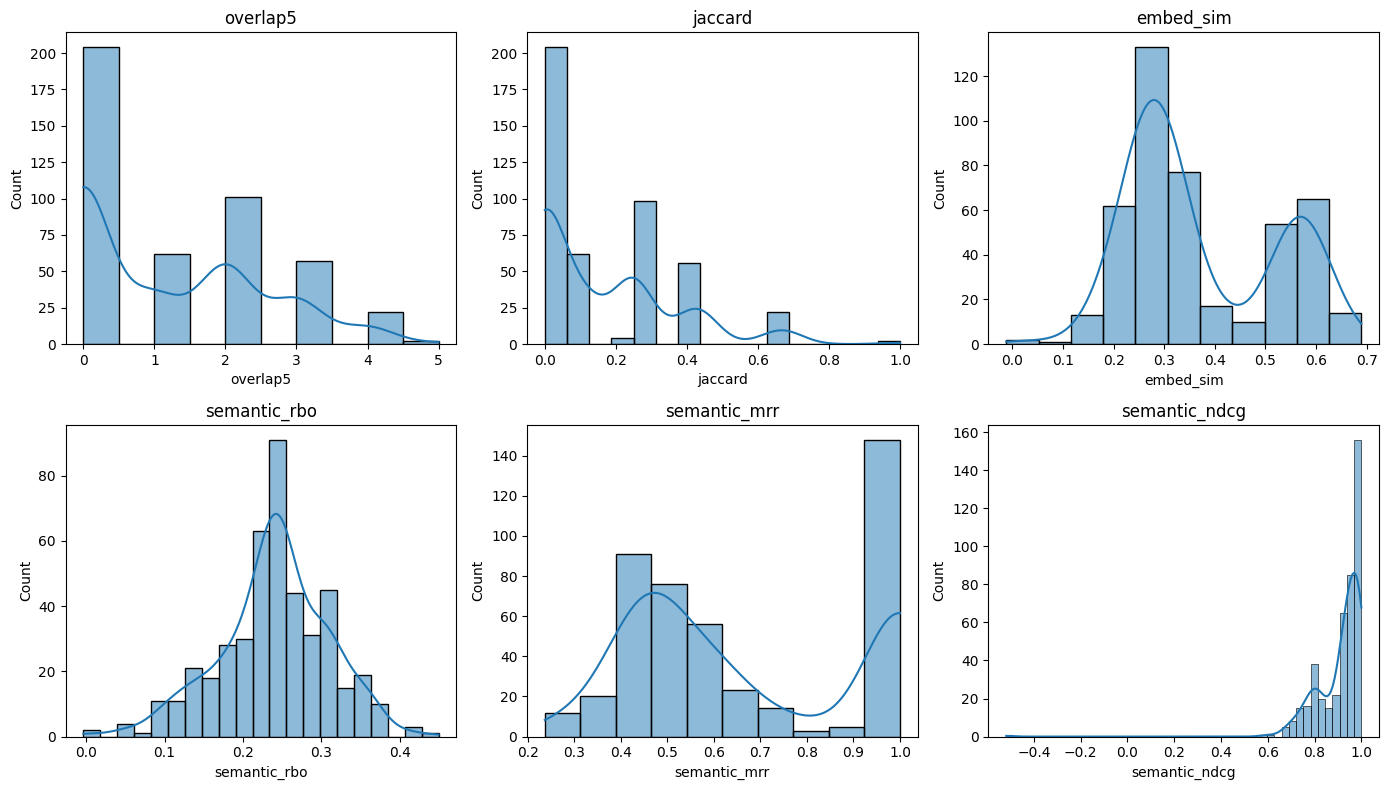

In [25]:
metrics = ["overlap5", "jaccard", "embed_sim", "semantic_rbo", "semantic_mrr", "semantic_ndcg"]

plt.figure(figsize=(14,8))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2,3,i)
    sns.histplot(df_full[metric], kde=True)
    plt.title(metric)
plt.tight_layout()
plt.show()


In [26]:
worst = df_full.sort_values("final_score").head(20)
worst[["index", "query", "our_str", "baseline_str", "final_percent"]]


,index,query,our_str,baseline_str,final_percent
300,301,"Играл в Hollow Knight: Silkwood Expansion, ест...","Hollow Knight: Godmaster, Ori Will of the Wisp...",Запрос не относится к подбору игр,9.252379
60,61,"Подскажи что-то в духе XCOM, но более простое.","Into the Breach, XCOM: Chimera Squad, Phantom ...","Mutant Year Zero: Road to Eden, Phoenix Point,...",30.576482
374,375,ищу игру где главный герой зелёный или может н...,"Yooka-Laylee, Rayman Legends, Oddworld: Abe’s ...","Tunic, Hollow Knight, A Hat in Time, Dead Cell...",30.686040
130,131,"Дай подобие Oxygen Not Included, но попроще.","Oxygen First Breath, Meeple Station, Mutant Ye...","Autonauts, Factory Town, Timberborn, Banished,...",30.864932
71,72,"Хочу короткий, но глубокий ролевой опыт.","Essays on Empathy, Hisato no Saku, Story, A Sm...","Disco Elysium, Citizen Sleeper, Undertale, Tra...",31.286795
6,7,"Хочу метроидванию, но чтобы была упорная иссле...","Escape From Tethys, Gemlands, Xecute, Deep Eni...","Axiom Verge, SteamWorld Dig 2, Blasphemous, Ca...",31.921135
80,81,"Подскажи игру, где можно путешествовать между ...","The Gunk, Hob, Dishonored 2 (тектоника миров),...","Riftbound, The Forgotten City, Omensight, Outw...",32.069970
376,377,хочу игру где боссы маленькие а игрок большой,"Katamari Damacy, Donut County, Tiny & Big: Gra...","Dead Cells, Titan Souls, Loop Hero, Hades, Sla...",32.619372
367,368,можно игру где кнопки работают сами,"Clicker Heroes, Cookie Clicker, Realm Grinder,...","Vampire Survivors, Brotato, Halls of Torment, ...",32.784092
4,5,"Ищу что-то похожее на Hollow Knight, но менее ...","Dungeon of Zolthan, Cave Story+, Insanely Twis...","Yoku's Island Express, Ender Lilies: Quietus o...",33.123317


In [27]:
best = df_full.sort_values("final_score", ascending=False).head(20)
best[["index", "query", "our_str", "baseline_str", "final_percent"]]


,index,query,our_str,baseline_str,final_percent
270,271,Скачай мне апдейт Overwatch 3.,"Игра не существует, обновление недоступно, про...",Запрос не относится к подбору игр,62.663201
318,319,Как разблокировать класс «Void Archer» в Diabl...,"Игра отсутствует, класс недоступен, проверь ис...",Запрос не относится к подбору игр,62.427862
228,229,"Что делать, если скопилось много ненужных вещей?","Сортировка по категориям, продажа онлайн, отда...",Запрос не относится к подбору игр,61.731907
274,275,Что играмет говорят про Counter-Strike Global ...,"Игра не анонсирована, информации нет, проверь ...",Запрос не относится к подбору игр,61.527576
237,238,Какие лайфхаки есть для готовки без масла?,"Готовка на пару, запекание, антипригарная сков...",Запрос не относится к подбору игр,61.352856
255,256,"Запусти, пожалуйста, Cyberpunk 2099 на моём ПК.","Игра не существует, запуск невозможен, проверь...",Запрос не относится к подбору игр,61.301878
242,243,Как научиться красиво писать от руки?,"Регулярные прописи, медленная практика, удобна...",Запрос не относится к подбору игр,61.189344
170,171,Как выбрать нишу для онлайн-бизнеса?,"Оценить спрос, конкурентов, маржинальность, ли...",Запрос не относится к подбору игр,61.152533
240,241,Как избавиться от привычки есть сладкое каждый...,"Снижать сладкое постепенно, больше воды, замен...",Запрос не относится к подбору игр,61.118535
254,255,Можешь обновить мне Assassin’s Creed Ragnarok?,"Игра не существует, обновление невозможно, про...",Запрос не относится к подбору игр,61.110029
